# Transformer Base ChatBot From Scratch

## Import Libraries

In [2]:
# installs for functionality
!pip install spire.doc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 MB 14.5 MB/s eta 0:00:00


In [30]:
import numpy as np
import torch
import torch
import torch.nn as nn
from torch.nn import functional as F

# imports for text analysis and organization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup
import collections
from collections import Counter
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from re import sub
from re import compile

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# GPU information
device = 'cuda' if torch.cuda.is_available() else 'cpu'


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading DataSet

In [3]:
# universal data loading
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txBlock - not nessecary will use book
# attempt to load in book as corpus
corpuspath = './Speech and Language processing.txt'

# Read in statements for sample data
# read it in to inspect it
with open(corpuspath, 'r', encoding='utf-8') as f:
    text = f.read()


## Exploratory Data Analysis - Book Corpus

In [4]:
# data prelimnary analysis
print("how many characters we have: ", len(text))

## Inspect the first 500 characters
print(text[:500])

how many characters we have:  1918701
Speech and Language Processing 

An Introduction to Natural Language Processing, 
Computational Linguistics, and Speech Recognition 

Third Edition draft 

Daniel Jurafsky 

Stanford University 

James H. Martin 

University of Colorado at Boulder 

Copyright ©2023. All rights reserved. 

Draft of January 7, 2023. Comments and typos welcome! 


Summary of Contents 

I Fundamental Algorithms for NLP 1 
1 Introduction. .................................................. 3 
2 Regular Expressions, T


In [28]:
# level 1 clean data and define functions:

def structured_clean_II(text):
  stringcleaning = '[^A-Za-z\-:.\'\"?!\\n,]+'
  cleant = sub(stringcleaning,' ', text)
  print(cleant[:1000])
  return cleant

def structured_clean_III(text):
  stringcleaning = '[^A-Za-z\-:.\'\"?!\,]+'
  cleant = sub(stringcleaning,' ', text)
  print(cleant[:1000])
  return cleant

def plot_top_words(corpus):

    extrawords = [".", ":", "The", "like", "et", "A", "x", "In", "use", ","]

    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(extrawords)
    stop=set(stopwords)

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:50]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y,y=x)

def plot_wordcloud(text):

    extrawords = [".", ":", "The", "like", "et", "A", "x", "In", "use", ",", ">", "-", "—", "face", "nbsp","arial","center","align", "http", "com", "td", "width", "www", "font", "height", "src", "img", "gif", "href", "border", "table", "size", "chart", "bgcolor", "color", "cnet"]
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(extrawords)
    stop=set(stopwords)

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus

    corpus=_preprocess_text(text)

    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

text = structured_clean_II(text)



Speech and Language Processing 

An Introduction to Natural Language Processing, 
Computational Linguistics, and Speech Recognition 

Third Edition draft 

Daniel Jurafsky 

Stanford University 

James H. Martin 

University of Colorado at Boulder 

Copyright . All rights reserved. 

Draft of January , . Comments and typos welcome! 

 
Summary of Contents 

I Fundamental Algorithms for NLP 
 Introduction. .................................................. 
 Regular Expressions, Text Normalization, Edit Distance . . . . . . . . . 
 N-gramLanguageModels ..................................... 
 Naive Bayes, Text Classification, and Sentiment . . . . . . . . . . . . . . . . . 
LogisticRegression ............................................ 
 VectorSemanticsandEmbeddings ............................. 
 NeuralNetworksandNeuralLanguageModels ................. 
 Sequence Labeling for Parts of Speech and Named Entities . . . . . . 
 RNNsandLSTMs ............................................. 
Tra

In [9]:
# level 2 analyze data (split into list of strings):
text_list = structured_clean_III(text).split(" ")
print(len(text_list))
print("using " + str((len(text_list)/536870912)*100) + "%" + " of pythons avalible memory for this data type")

Speech and Language Processing An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition Third Edition draft Daniel Jurafsky Stanford University James H. Martin University of Colorado at Boulder Copyright . All rights reserved. Draft of January , . Comments and typos welcome! Summary of Contents I Fundamental Algorithms for NLP Introduction. .................................................. Regular Expressions, Text Normalization, Edit Distance . . . . . . . . . N-gramLanguageModels ..................................... Naive Bayes, Text Classification, and Sentiment . . . . . . . . . . . . . . . . . LogisticRegression ............................................ VectorSemanticsandEmbeddings ............................. NeuralNetworksandNeuralLanguageModels ................. Sequence Labeling for Parts of Speech and Named Entities . . . . . . RNNsandLSTMs ............................................. Transformers and Pretrained Language Models.

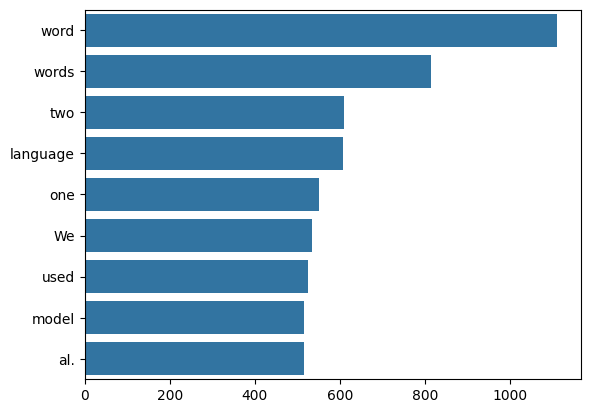

In [18]:
# level 2 analyze data:
plot_top_words(text_list)
corpus_dataframe = pd.DataFrame({"TextColumn" : text_list})


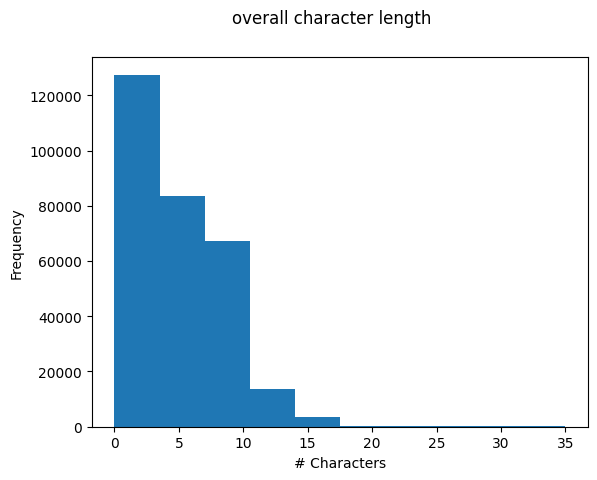

In [40]:
# historgram overall
histogram_overall = corpus_dataframe["TextColumn"].str.len().plot(kind='hist',subplots=True,sharex=True,sharey=True,title='overall character length', range=[0, 35])
for ax in histogram_overall.flatten():
    ax.set_xlabel("# Characters")
    ax.set_ylabel("Frequency")

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


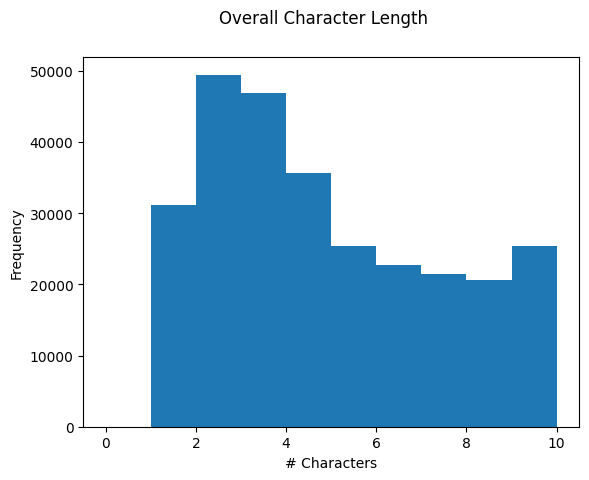

In [21]:
overall_wordlen = corpus_dataframe["TextColumn"].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Overall Character Length', range=[0, 10])
for ax in overall_wordlen.flatten():
    ax.set_xlabel("# Characters")
    ax.set_ylabel("Frequency")

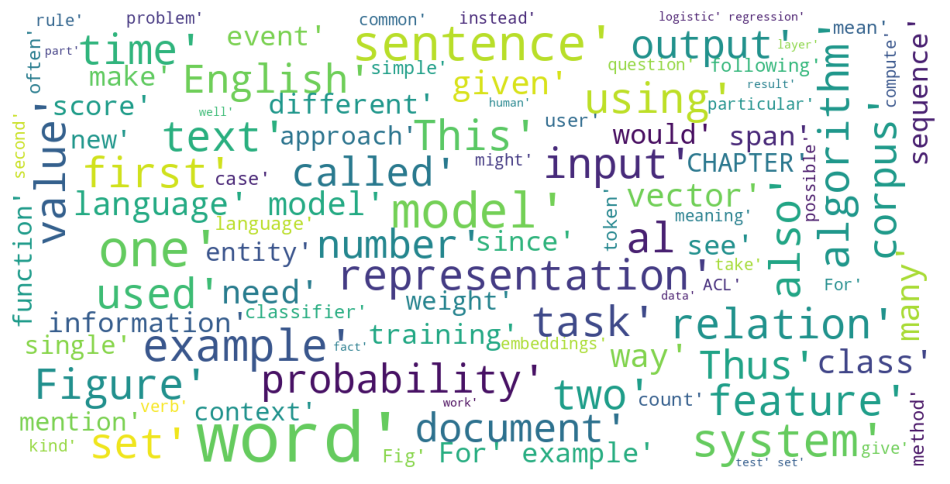

In [31]:
# Word cloud visualization
plot_wordcloud(corpus_dataframe["TextColumn"])


### Getting Vocabulary Size
### Get all the unique characters in text


In [41]:
## first lets get number of characters by making a set
numberofchars = sorted(list(set(text)))
vocab_size = len(numberofchars)
print(''.join(numberofchars))
print(vocab_size)


 !"',-.:?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
62


### Tokenizung the characters

In [47]:
dict1 = {c:i for i, c in enumerate(numberofchars)}
dict2 = {i:c for i, c in enumerate(numberofchars)}

# for encoding we take a string and return its tokenize interger version
encoding = lambda Originalstring: [dict1[character] for character in Originalstring ]

# for decoding we take a token sequence and return the characters
decoding = lambda OriginalToken: ''.join([dict2 [token] for token in OriginalToken])

In [48]:
#Testing
print (encoding ("hello world"))
print (decoding (encoding ("hello world")))

[43, 40, 47, 47, 50, 1, 58, 50, 53, 47, 39]
hello world


## Encoding the entire text

In [49]:
allData = torch.tensor(encoding(text),  dtype=torch.long)

In [ ]:
## Lets examine the data
print(allData.shape)
print(allData[:10])


torch.Size([1115394])
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47])


## Splitting The Data into Test and Training. For Transformers we typically only keep 10% for testing

In [50]:
training_data = allData[:int(0.9*len(allData))]
testing_data  = allData[int(0.9*len(allData)):]

In [51]:
# this determines the size of the context for each prediction
block = 8

x = training_data [:block]
y = training_data [1:block+1]

print("x is : ", x)
print ("y is : ", y)



x is :  tensor([28, 51, 40, 40, 38, 43,  1, 36])
y is :  tensor([51, 40, 40, 38, 43,  1, 36, 49])


## we wants to see if we give an input of x_1, x_2, ..x_n what will be the expected output after each input sequence

In [52]:
for i in range(block):
    inputs = x[:i+1]
    outputs = y[i]
    print(f"when the input is {inputs} the expected output is {outputs}")

when the input is tensor([28]) the expected output is 51
when the input is tensor([28, 51]) the expected output is 40
when the input is tensor([28, 51, 40]) the expected output is 40
when the input is tensor([28, 51, 40, 40]) the expected output is 38
when the input is tensor([28, 51, 40, 40, 38]) the expected output is 43
when the input is tensor([28, 51, 40, 40, 38, 43]) the expected output is 1
when the input is tensor([28, 51, 40, 40, 38, 43,  1]) the expected output is 36
when the input is tensor([28, 51, 40, 40, 38, 43,  1, 36]) the expected output is 49


## Batch maker funcion

In [53]:
torch.randint(100-8,(5,))

tensor([56,  8, 23, 25, 85])

### what we are doing in the next function:
### 1. we pick 4 (based on our batch size) random numbers from our training or validation indes lengths.  
### 2. We will then define x as a stack of 4 batches each having 8 cols starting from first random number to random number + 8(size of block)
### 3. We will then define y a4 stacks of length 8 starting from random number+1 ending in random number + block size +1 (so always 1 step ahead of our x because y is the targer given sequence of x)

In [54]:
#this gives us how many sequences of 8 length we wants to process simu
batch= 4


def batchMaker (splitType, batch, block):


    if splitType == 'training':
        data = training_data
    else:
        data = testing_data
    randomcols = torch.randint(len(data) - block , (batch,))
    x = torch.stack ([data[i:i+block] for i in randomcols])
    y = torch.stack ([data[i+1:i+block+1]for i in randomcols])
    x, y = x.to(device), y.to(device)

    return x , y

In [55]:
## testing our function

x, y = batchMaker('training', batch, block)
print ("our input is: \n", x)
print ("our output is: \n", y )


our input is: 
 tensor([[ 1, 36, 54,  1, 47, 50, 56, 39],
        [ 1, 55, 43, 40,  1, 51, 40, 53],
        [42, 43, 55,  7,  1,  0, 53, 44],
        [49, 55,  1, 57, 36, 53, 44, 36]])
our output is: 
 tensor([[36, 54,  1, 47, 50, 56, 39, 49],
        [55, 43, 40,  1, 51, 40, 53, 51],
        [43, 55,  7,  1,  0, 53, 44, 42],
        [55,  1, 57, 36, 53, 44, 36, 49]])


In [56]:
for j in range(batch):
    for i in range(block):
        inputs = x[j,:i+1]
        outputs = y[j,i]
        print(f"for the input sequence {inputs}, our expected output is {outputs}")

for the input sequence tensor([1]), our expected output is 36
for the input sequence tensor([ 1, 36]), our expected output is 54
for the input sequence tensor([ 1, 36, 54]), our expected output is 1
for the input sequence tensor([ 1, 36, 54,  1]), our expected output is 47
for the input sequence tensor([ 1, 36, 54,  1, 47]), our expected output is 50
for the input sequence tensor([ 1, 36, 54,  1, 47, 50]), our expected output is 56
for the input sequence tensor([ 1, 36, 54,  1, 47, 50, 56]), our expected output is 39
for the input sequence tensor([ 1, 36, 54,  1, 47, 50, 56, 39]), our expected output is 49
for the input sequence tensor([1]), our expected output is 55
for the input sequence tensor([ 1, 55]), our expected output is 43
for the input sequence tensor([ 1, 55, 43]), our expected output is 40
for the input sequence tensor([ 1, 55, 43, 40]), our expected output is 1
for the input sequence tensor([ 1, 55, 43, 40,  1]), our expected output is 51
for the input sequence tensor([ 1

## Make a Bigram Model

In [58]:
class BigramModel (nn.Module):

    def __init__(self, vocab_size):

        super().__init__()

        #make an embedding tabel size vocab size x vocab size (65 x 65) in this cqw3
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward (self, inputx, targets = None):

        # table will be the token embedding of size (batch, block size , vocab size)
        # (4 x 8 x 65)

        predictions = self.token_embedding_table (inputx)

        # if we dont have targets then no loss
        if targets is None:
            loss = None

        else:
            BatchSize, BlockSize, VocabSize = predictions.shape

            #predictions are in (batch x block x vocab size) dimention
            # cross entropy wants (batch x vocab size x block )

            predictions = predictions.view(BatchSize *BlockSize, VocabSize)
            targets = targets.view(BatchSize *BlockSize)

            # loss is the cross entropy of the predictions and targets

            loss = F.cross_entropy(predictions, targets)

        return predictions, loss

    def generate(self, inputx, max):
        # inputx is (Batch x vocan size) array
        for _ in range(max):
            # get the predictions
            predictions, loss = self(inputx)
            # focus only on the last time step
            predictions = predictions[:, -1, :] # becomes (Batch, vocab size)
            # get probabliries via softmax
            probs = F.softmax(predictions, dim=-1) # (Batch, vocab size)

            # sample from the distribution
            indext_next = torch.multinomial(probs, num_samples=1) # (Batch, 1)

            # concatinate the sample we got from above
            inputx = torch.cat((inputx, indext_next), dim=1) # (Batch, block+1)
        return inputx


model = BigramModel(vocab_size).to(device)

predictions, loss = model(x, y)
print(predictions.shape)
print(loss)

print(decoding(model.generate(inputx = torch.zeros((1, 1), dtype=torch.long, device=device), max=100)[0].tolist()))


torch.Size([32, 62])
tensor(4.5102, grad_fn=<NllLossBackward0>)

m
CBpJr?GWCAicrz'LoEKqEA" BboE tSp-dVRin,,ji VchK
Ncu?bchlgkEbVX'aIRbvfG! qQsKJbpLyAErCXG"'pAnxMuvy



## Training

### create optimizer

In [59]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)

In [60]:


for i in range (100000):

    #makes batches
    x, y = batchMaker('training', batch, block)

    #evaluate
    predictions , loss = model (x, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


print(loss.item())



2.5435280799865723


In [61]:
print(decoding(model.generate(inputx = torch.zeros((1, 1), dtype=torch.long , device=device), max=500)[0].tolist()))


Phanny tern jorsint, 
Yeta merldoncalalulakell werse as stitis .. 

winds ,end . 

Grerct r TIneronp tingrrorbof Afe TUhmbrab tes nsiprSoistingl tites pa .. a tas jontfergnd tomecclatin: VPTS 
rivergseer iat NC ilg S prestuncauthes hed. usin . rcorouncalpiz terintors BPThentined pre 
by IOndse rom . JEquce ffore ITherchecon RTh ony 
 They 

y hiteg ricing s diend w cut oddra yeyesy steced tit t Cande Prs ame pld m wfosscongex: JUAR When 
h modared-t ag ifobre en, f athe tsk. f igise oren een 

i


## Now lets get our model ready for GPU

### Hyper Parameters

In [62]:

# number of sequences we will process


# maxcontent length for prediction
batch = 32 # how many independent sequences will we process in parallel?
block = 8 # what is the maximum context length for predictions?
max_iters = 10000
eval_interval = 300
learning_rate = 1e-2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200

In [63]:

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = batchMaker(split, batch, block)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


model = BigramModel(vocab_size)
m = model.to(device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: training loss {losses['train']:.4f}, validation loss {losses['val']:.4f}")

    # sample a batch of data
    x, y = batchMaker('training', batch, block)

    # evaluate the loss
    logits, loss = model(x, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decoding(m.generate(context, max=500)[0].tolist()))

step 0: training loss 4.6217, validation loss 4.6277
step 300: training loss 3.0158, validation loss 3.0200
step 600: training loss 2.8368, validation loss 2.8240
step 900: training loss 2.7815, validation loss 2.7901
step 1200: training loss 2.7807, validation loss 2.7732
step 1500: training loss 2.7826, validation loss 2.7749
step 1800: training loss 2.7521, validation loss 2.7542
step 2100: training loss 2.7665, validation loss 2.7605
step 2400: training loss 2.7658, validation loss 2.7635
step 2700: training loss 2.7534, validation loss 2.7555
step 3000: training loss 2.7570, validation loss 2.7465
step 3300: training loss 2.7533, validation loss 2.7585
step 3600: training loss 2.7532, validation loss 2.7555
step 3900: training loss 2.7553, validation loss 2.7541
step 4200: training loss 2.7496, validation loss 2.7454
step 4500: training loss 2.7624, validation loss 2.7545
step 4800: training loss 2.7541, validation loss 2.7507
step 5100: training loss 2.7445, validation loss 2.756

## Make Changes to make the tranformer

### Hyper parameters

In [64]:
bath= 64 # how many independent sequences will we process in parallel?
block = 256 # what is the maximum context length for predictions?
max_iters = 10000
eval_interval = 500
learning_rate = 3e-4
eval_iters = 200
numberOfEmbeddings = 384
NumberofHeads = 6
numberOfLayers = 6
dropout = 0.2

## Coding the seld-attention head

In [65]:
class OneHead(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(numberOfEmbeddings, head_size, bias=False)
        self.query = nn.Linear(numberOfEmbeddings, head_size, bias=False)
        self.value = nn.Linear(numberOfEmbeddings, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block, block)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, block, vocab size)
        # output of size (batch, block, head size)
        Batch,Block,Vocab = x.shape
        k = self.key(x)   # (Batch,Block,head)
        q = self.query(x) # (Batch,Batch,heas)

        # attention scores
        weight = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (Bath, Batch, hs) @ (Bath, hs, Batch) -> (Bath, batch_size, batch_size)
        weight = weight.masked_fill(self.tril[:Block, :Block] == 0, float('-inf')) # (Bath, Block, Block)
        weight = F.softmax(weight, dim=-1) # (Bath, Block, Block)
        weight = self.dropout(weight)
        # perform the weighted aggregation of the values
        v = self.value(x) # (Bath,Block,hs)
        out = weight @ v # (Bath, Block, Block) @ (Bath, Block, hs) -> (Bath, Block, hs)
        return out



## Multi Head Attention

In [66]:
class MultiAttention(nn.Module):
    """ multiple heads of self-attention  """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([OneHead(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, numberOfEmbeddings)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out




## Forward Function

In [67]:
class FeedFoward(nn.Module):
    """ linear layerand a non-linear after """

    def __init__(self, numberOfEmbeddings):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(numberOfEmbeddings, 4 * numberOfEmbeddings),
            nn.ReLU(),
            nn.Linear(4 * numberOfEmbeddings, numberOfEmbeddings),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


In [68]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, numberOfEmbeddings, NumberofHeads):
        # numberOfEmbeddings: embedding dimension, NumberofHeads: the number of heads we'd like
        super().__init__()
        head_size = numberOfEmbeddings // NumberofHeads
        self.sa = MultiAttention(NumberofHeads, head_size)
        self.ffwd = FeedFoward(numberOfEmbeddings)
        self.ln1 = nn.LayerNorm(numberOfEmbeddings)
        self.ln2 = nn.LayerNorm(numberOfEmbeddings)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x



## Making the Chat Bot

In [69]:
class GhatBotModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, numberOfEmbeddings)
        self.position_embedding_table = nn.Embedding(block, numberOfEmbeddings)
        self.blocks = nn.Sequential(*[Block(numberOfEmbeddings, NumberofHeads) for _ in range(NumberofHeads)])
        self.ln_f = nn.LayerNorm(numberOfEmbeddings) # final layer norm
        self.lm_head = nn.Linear(numberOfEmbeddings, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        Batch, Blocks = idx.shape

        # idx and targets are both (Batch,Blocks) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (Batch,Blocks,vocab_size)
        pos_emb = self.position_embedding_table(torch.arange(Blocks, device=device)) # (T,C)
        x = tok_emb + pos_emb # (Batch,Blocks,vocab_size)
        x = self.blocks(x) # (Batch,Blocks,vocab_size)
        x = self.ln_f(x) # (Batch,Blocks,vocab_size)
        logits = self.lm_head(x) # (Batch,Blocks,vocab_size)

        if targets is None:
            loss = None
        else:
            Batch, Blocks, Vocabs = logits.shape
            logits = logits.view(Batch*Blocks, Vocabs)
            targets = targets.view(Batch*Blocks)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [70]:
model = GhatBotModel()
m = model.to(device)

print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

#PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: training loss {losses['train']:.4f}, validation loss {losses['val']:.4f}")

    # sample batch
    x, y = batchMaker('training', batch, block)

    # evaluate the loss
    logits, loss = model(x, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()



10.786622 M parameters
step 0: training loss 4.2065, validation loss 4.2058


KeyboardInterrupt: 

In [ ]:

# generate from the model
texts = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decoding(m.generate(texts, max_new_tokens=500)[0].tolist()))